In [36]:
# Importing needed libraries

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import pickle
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
cars_list=pd.read_excel("Final_data.xlsx")

In [3]:
cars_list.columns

Index(['Unnamed: 0', 'Car_model', 'Year_of_car_manufacture',
       'Kilometers_driven', 'Number_of_previous_owners', 'Transmission_type',
       'Fuel_type', 'Body_type', 'city', 'Price'],
      dtype='object')

In [4]:
cars_list= cars_list.drop(['Unnamed: 0'],axis=1)

In [5]:
# Replacing comma in values
cars_list['Kilometers_driven'] = cars_list['Kilometers_driven'].str.replace(',', '')

In [6]:
cars_list['Kilometers_driven'] = pd.to_numeric(cars_list['Kilometers_driven'])

In [7]:
cars_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Car_model                  8369 non-null   object 
 1   Year_of_car_manufacture    8369 non-null   int64  
 2   Kilometers_driven          8369 non-null   int64  
 3   Number_of_previous_owners  8369 non-null   int64  
 4   Transmission_type          8369 non-null   object 
 5   Fuel_type                  8369 non-null   object 
 6   Body_type                  8369 non-null   object 
 7   city                       8369 non-null   object 
 8   Price                      8259 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 588.6+ KB


In [8]:
cars_list.describe()

,Year_of_car_manufacture,Kilometers_driven,Number_of_previous_owners,Price
count,8369.000000,8.369000e+03,8369.000000,8.259000e+03
mean,2016.503286,5.897430e+04,1.360139,9.687569e+05
std,3.921465,7.406100e+04,0.641958,1.421848e+06
min,1985.000000,0.000000e+00,0.000000,1.000000e+05
25%,2014.000000,3.000000e+04,1.000000,4.000000e+05
50%,2017.000000,5.369200e+04,1.000000,6.130000e+05
75%,2019.000000,8.000000e+04,2.000000,9.500000e+05
max,2023.000000,5.500000e+06,5.000000,4.150000e+07


In [9]:
cars_list.duplicated().sum()

np.int64(140)

In [10]:
cars_list.isnull().sum()

Car_model                      0
Year_of_car_manufacture        0
Kilometers_driven              0
Number_of_previous_owners      0
Transmission_type              0
Fuel_type                      0
Body_type                      0
city                           0
Price                        110
dtype: int64

In [11]:
sp_list  = []

for i in cars_list.columns:
  perc_zero = (cars_list[i]==0).mean() * 100
  sp_list.append(perc_zero)



In [12]:
pd.DataFrame({
    "Columns": cars_list.columns,
    "S-Perc": sp_list
})

,Columns,S-Perc
0,Car_model,0.000000
1,Year_of_car_manufacture,0.000000
2,Kilometers_driven,0.023898
3,Number_of_previous_owners,0.382363
4,Transmission_type,0.000000
5,Fuel_type,0.000000
6,Body_type,0.000000
7,city,0.000000
8,Price,0.000000


In [13]:
# Filling null values with mode
cars_list['Body_type'] = cars_list['Body_type'].fillna(cars_list['Body_type'].mode()[0])

# Median imputation
cars_list['Price'].fillna(cars_list['Price'].median(), inplace=True)

C:\Users\Vijay\AppData\Local\Temp\ipykernel_5408\2163254445.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_list['Price'].fillna(cars_list['Price'].median(), inplace=True)


In [14]:
cars_list

,Car_model,Year_of_car_manufacture,Kilometers_driven,Number_of_previous_owners,Transmission_type,Fuel_type,Body_type,city,Price
0,Kia Sonet,2022,20000,1,Automatic,Petrol,SUV,Chennai,1150000.0
1,Maruti Eeco,2015,20687,1,Manual,Petrol,Minivans,Chennai,415000.0
2,Nissan Magnite,2021,30000,1,Manual,Petrol,SUV,Chennai,750000.0
3,Hyundai i10,2015,59247,1,Manual,Petrol,Hatchback,Chennai,398000.0
4,Honda Jazz,2015,50000,1,Manual,Petrol,Hatchback,Chennai,550000.0
...,...,...,...,...,...,...,...,...,...
8364,Honda City,2019,60000,1,Automatic,Petrol,Sedan,Delhi,900000.0
8365,Kia Sonet,2021,20000,1,Manual,Petrol,SUV,Delhi,950000.0
8366,Hyundai Verna,2011,60000,1,Manual,Petrol,Sedan,Delhi,418000.0
8367,Hyundai Creta,2019,38000,1,Manual,Diesel,SUV,Delhi,1195000.0


In [15]:
# Data Quality Checking

def perform_data_quality_checks(data):
    duplicate_rows = data[data.duplicated()]
    if not duplicate_rows.empty:
        print("Duplicate Rows:")
        print(duplicate_rows)
    else:
        print("No duplicate rows found.")

    missing_values = data.isnull().sum()
    if not missing_values.empty:
        print("\nMissing Values:")
        print(missing_values)
    else:
        print("\nNo missing values found.")

    data_types = data.dtypes
    print("\nData Types:")
    print(data_types)


perform_data_quality_checks(cars_list)

Duplicate Rows:
              Car_model  Year_of_car_manufacture  Kilometers_driven  \
55          Maruti Ciaz                     2017              80000   
77        Maruti Baleno                     2016              53967   
78          Honda Amaze                     2014              99225   
179           MG Hector                     2022              20000   
194          Honda City                     2012              71423   
...                 ...                      ...                ...   
8044        Ford Aspire                     2015             100000   
8126  Mercedes-Benz CLA                     2018              40000   
8188         Kia Seltos                     2021              20000   
8324      Toyota Glanza                     2022              30000   
8342         Maruti SX4                     2009             110000   

      Number_of_previous_owners Transmission_type Fuel_type  Body_type  \
55                            1            Manual    Dies

In [16]:
cars_list.shape

(8369, 9)

In [17]:
cars_list = cars_list.drop_duplicates()
print("After removing Duplicates:", len(cars_list))

After removing Duplicates: 8229


In [18]:
cars_list.to_excel("Final_Cardheko_list.xlsx")

In [19]:
df_1= pd.read_excel("Final_Cardheko_list.xlsx")

In [20]:
df_1= df_1.drop('Unnamed: 0', axis=1)

In [21]:
df_1

,Car_model,Year_of_car_manufacture,Kilometers_driven,Number_of_previous_owners,Transmission_type,Fuel_type,Body_type,city,Price
0,Kia Sonet,2022,20000,1,Automatic,Petrol,SUV,Chennai,1150000.0
1,Maruti Eeco,2015,20687,1,Manual,Petrol,Minivans,Chennai,415000.0
2,Nissan Magnite,2021,30000,1,Manual,Petrol,SUV,Chennai,750000.0
3,Hyundai i10,2015,59247,1,Manual,Petrol,Hatchback,Chennai,398000.0
4,Honda Jazz,2015,50000,1,Manual,Petrol,Hatchback,Chennai,550000.0
...,...,...,...,...,...,...,...,...,...
8224,Honda City,2019,60000,1,Automatic,Petrol,Sedan,Delhi,900000.0
8225,Kia Sonet,2021,20000,1,Manual,Petrol,SUV,Delhi,950000.0
8226,Hyundai Verna,2011,60000,1,Manual,Petrol,Sedan,Delhi,418000.0
8227,Hyundai Creta,2019,38000,1,Manual,Diesel,SUV,Delhi,1195000.0


In [23]:
# Plot for distribution of prices 

plt.figure(figsize=(6, 6))
fig = px.histogram(df_1, x='Price', title='Distribution of Prices')
fig.update_layout(xaxis_title='Price', yaxis_title='Frequency')
fig.show()


<Figure size 600x600 with 0 Axes>

In [24]:
df_1['Body_type'].mode()[0]

'Hatchback'

In [22]:
df_1['Price'].median()

np.float64(613000.0)

In [26]:
# Boxplot for kms driven

fig = px.box(df_1, x='Kilometers_driven', y='Price', title='Boxplot of Kilometers Driven vs. Price')
fig.update_layout(xaxis_title='Kilometers Driven', yaxis_title='Price')
fig.show()


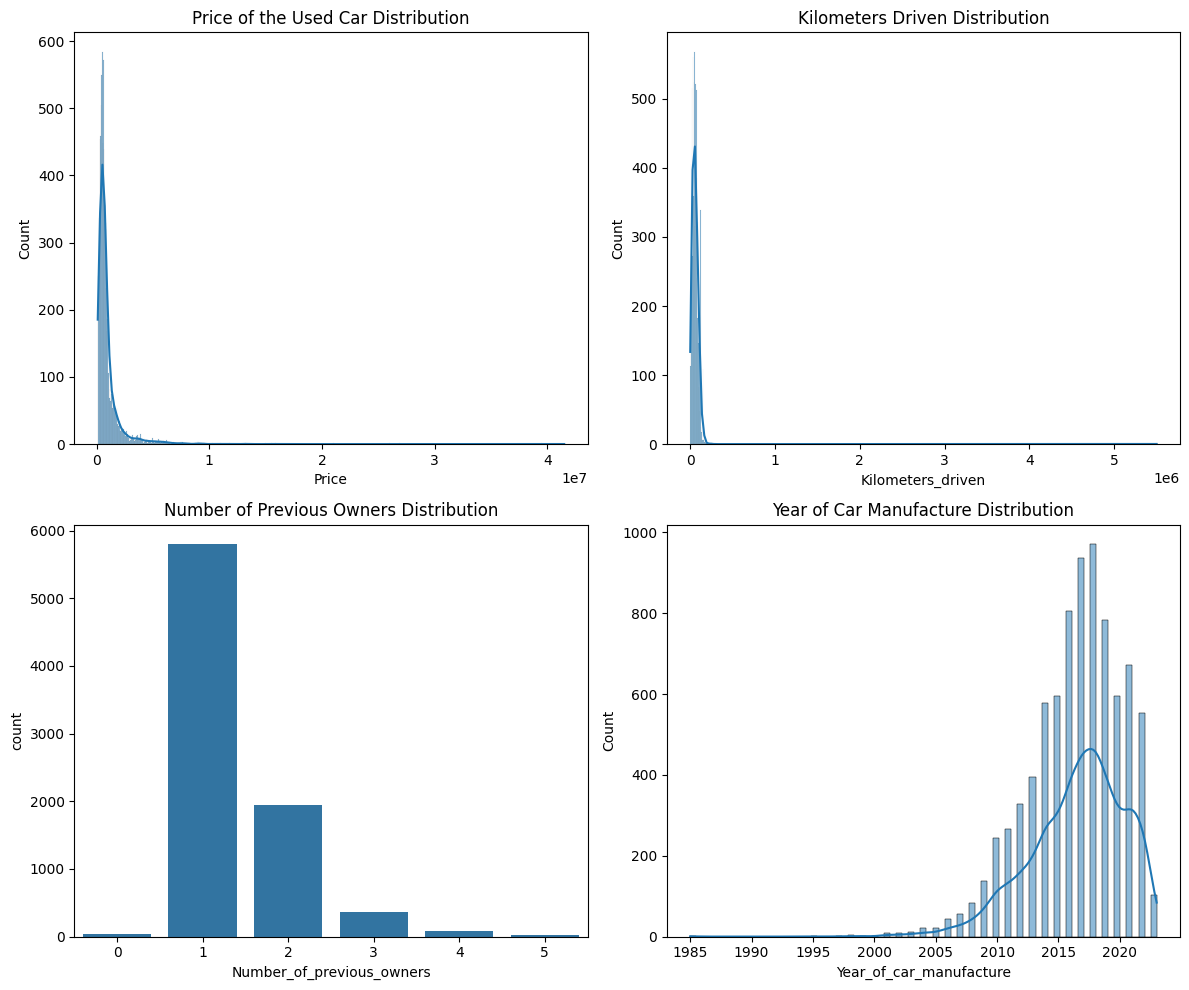

In [27]:
# Setting up the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot for Price_of_the_used_car
sns.histplot(data=df_1, x='Price', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price of the Used Car Distribution')

# Plot for Kms driven
sns.histplot(data=df_1, x='Kilometers_driven', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Kilometers Driven Distribution')

# Plot No of Previous owners
sns.countplot(data=df_1, x='Number_of_previous_owners', ax=axes[1, 0])
axes[1, 0].set_title('Number of Previous Owners Distribution')

# Plot Year_of_car_manufacture
sns.histplot(data=df_1, x='Year_of_car_manufacture', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Year of Car Manufacture Distribution')


plt.tight_layout()
plt.show()

In [28]:
# Bar plot for Categorical features 
categorical_features = ['city', 'Fuel_type', 'Body_type', 'Transmission_type']
fig = go.Figure()

# Plotting count plots for categorical features

for feature in categorical_features:
    if feature == 'Body_type':
        fig.add_trace(go.Bar(x=df_1[feature].value_counts().index, 
                             y=df_1[feature].value_counts().values,
                             name=f'Distribution of {feature}', marker_color='lightskyblue'))
    else:
        fig.add_trace(go.Bar(x=df_1[feature].value_counts().index, 
                             y=df_1[feature].value_counts().values,
                             name=f'Distribution of {feature}'))

# Update layout for categorical features
fig.update_layout(title='Distribution of Categorical Features',
                  xaxis_title='Category',
                  yaxis_title='Count')


fig.show()

In [29]:
# Heat map for numerical features 
numerical_features = ['Price', 'Kilometers_driven', 'Number_of_previous_owners', 'Year_of_car_manufacture']

# correlation
correlation_matrix = df_1[numerical_features].corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Viridis',
    colorbar=dict(title='Correlation'),
))

fig.show()

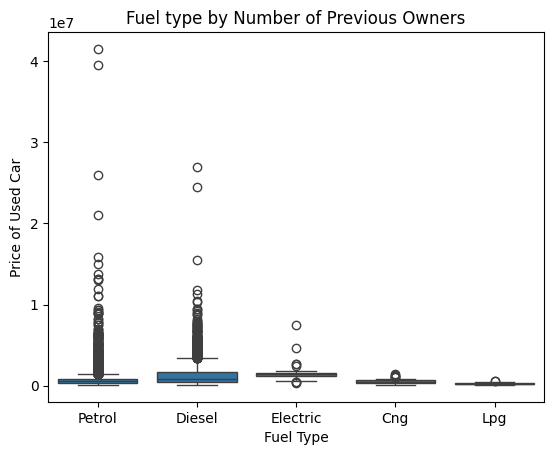

In [30]:
# Boxplot for fuel type

sns.boxplot(data=df_1, x='Fuel_type', y='Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price of Used Car')
plt.title('Fuel type by Number of Previous Owners')
plt.show()



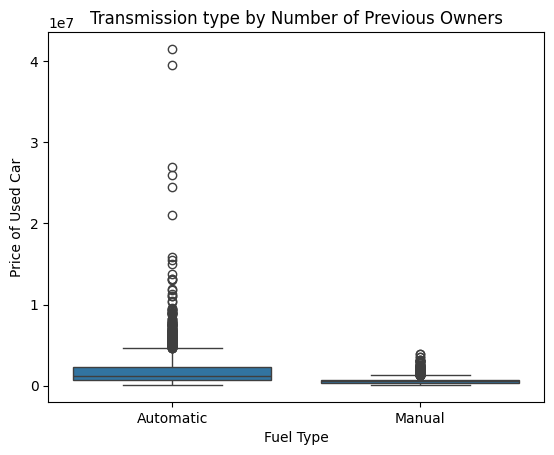

In [31]:
# Boxplot for tranmission type

sns.boxplot(data=df_1, x='Transmission_type', y='Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price of Used Car')
plt.title('Transmission type by Number of Previous Owners')
plt.show()


In [32]:
# Selecting numerical columns
numeric_columns = df_1.select_dtypes(include=['number'])

# correlation 
correlation_with_price = numeric_columns.corr()['Price'].drop('Price')

# heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_with_price.values.reshape(1, -1),
    x=correlation_with_price.index,
    y=['Price'],
    colorscale='RdBu',
    colorbar=dict(title='Correlation'),
))


fig.update_layout(
    title='Correlation with Price',
    xaxis_title='Features',
    yaxis_title='Price',
)
fig.show()

In [23]:
# ANOVA test to checking categorical columns are relating to output

categorical_columns = df_1.select_dtypes(include=['object'])

#list to store results
anova_results = []

# Performing ANOVA for each categorical column
for column in categorical_columns:
    model = ols('Price ~ ' + column, data=df_1).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table.loc[column, 'PR(>F)']
    anova_results.append((column, p_value))

# ANOVA results
for column, p_value in anova_results:
    if p_value < 0.05:  # Significance level of 0.05
        print(f'{column}: p-value = {p_value} (Statistically significant)')
    else:
        print(f'{column}: p-value = {p_value} (Not statistically significant)')


Car_model: p-value = 0.0 (Statistically significant)
Transmission_type: p-value = 0.0 (Statistically significant)
Fuel_type: p-value = 2.5573122444951943e-69 (Statistically significant)
Body_type: p-value = 5.533130327238604e-277 (Statistically significant)
city: p-value = 8.198755010105005e-41 (Statistically significant)


In [34]:
df_1

,Car_model,Year_of_car_manufacture,Kilometers_driven,Number_of_previous_owners,Transmission_type,Fuel_type,Body_type,city,Price
0,Kia Sonet,2022,20000,1,Automatic,Petrol,SUV,Chennai,1150000.0
1,Maruti Eeco,2015,20687,1,Manual,Petrol,Minivans,Chennai,415000.0
2,Nissan Magnite,2021,30000,1,Manual,Petrol,SUV,Chennai,750000.0
3,Hyundai i10,2015,59247,1,Manual,Petrol,Hatchback,Chennai,398000.0
4,Honda Jazz,2015,50000,1,Manual,Petrol,Hatchback,Chennai,550000.0
...,...,...,...,...,...,...,...,...,...
8224,Honda City,2019,60000,1,Automatic,Petrol,Sedan,Delhi,900000.0
8225,Kia Sonet,2021,20000,1,Manual,Petrol,SUV,Delhi,950000.0
8226,Hyundai Verna,2011,60000,1,Manual,Petrol,Sedan,Delhi,418000.0
8227,Hyundai Creta,2019,38000,1,Manual,Diesel,SUV,Delhi,1195000.0


In [24]:

#features and target
features = df_1[['Car_model', 'Year_of_car_manufacture', 'Kilometers_driven',
                 'Number_of_previous_owners', 'Transmission_type', 'Fuel_type',
                 'Body_type', 'city']]
target = df_1['Price']

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=32)

In [25]:
# Checking for empty rows in x_train
empty_rows_train = x_train.isnull().any(axis=1)

# Checing for empty rows in x_test
empty_rows_test = x_test.isnull().any(axis=1)

print("Number of empty rows in x_train:", empty_rows_train.sum())
print("Number of empty rows in x_test:", empty_rows_test.sum())


Number of empty rows in x_train: 0
Number of empty rows in x_test: 0


In [25]:
df_1.select_dtypes(include=['object'])

,Car_model,Transmission_type,Fuel_type,Body_type,city
0,Kia Sonet,Automatic,Petrol,SUV,Chennai
1,Maruti Eeco,Manual,Petrol,Minivans,Chennai
2,Nissan Magnite,Manual,Petrol,SUV,Chennai
3,Hyundai i10,Manual,Petrol,Hatchback,Chennai
4,Honda Jazz,Manual,Petrol,Hatchback,Chennai
...,...,...,...,...,...
8224,Honda City,Automatic,Petrol,Sedan,Delhi
8225,Kia Sonet,Manual,Petrol,SUV,Delhi
8226,Hyundai Verna,Manual,Petrol,Sedan,Delhi
8227,Hyundai Creta,Manual,Diesel,SUV,Delhi


In [26]:
# Changing 'Manual' with 0 and 'Automatic' with 1 in the 'Transmission_type' column 
x_train['Transmission_type'].replace({'Manual': 0, 'Automatic': 1}, inplace=True)
x_test['Transmission_type'].replace({'Manual': 0, 'Automatic': 1}, inplace=True)

C:\Users\Vijay\AppData\Local\Temp\ipykernel_5408\1231591364.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['Transmission_type'].replace({'Manual': 0, 'Automatic': 1}, inplace=True)
C:\Users\Vijay\AppData\Local\Temp\ipykernel_5408\1231591364.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tru

In [27]:

#mapping of fuel types to numerical values

fuel_type_mapping = {
    'Petrol': 1,
    'Diesel': 2,
    'Cng': 3,
    'Electric': 4,
    'Lpg': 5
}

# Apply mapping to the 'Fuel_type' column 
x_train['Fuel_type'] = x_train['Fuel_type'].map(fuel_type_mapping)
x_test['Fuel_type'] = x_test['Fuel_type'].map(fuel_type_mapping)


In [28]:
# Scaling
scaler=MinMaxScaler()
col=['Kilometers_driven','Year_of_car_manufacture','Number_of_previous_owners']

# Combining x_training and x_testing data for Scaling
combined_scale_data = pd.concat([x_train[col], x_test[col]], axis=0)

# Fitting 
scaler.fit(combined_scale_data)

# Encoding both training and testing data
x_train_scaled = scaler.transform(x_train[col])
x_test_scaled = scaler.transform(x_test[col])

# encoded values in the DataFrames
x_train[col] = x_train_scaled
x_test[col] = x_test_scaled

In [40]:
Regression_Models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
    'ElasticNet Regression': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}),
    'Huber Regressor': (HuberRegressor(), {'epsilon': [1.0, 1.5, 2.0],'max_iter':[1000]}),
    'Bayesian Ridge Regression': (BayesianRidge(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'criterion': ['friedman_mse'], 'max_depth': [None, 5, 10]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [3, 5, 7]}),
    'XG Boost': (XGBRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [3, 5, 7]}),
    #'Support Vector Machine': (SVR(), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1.0, 10.0]}),
    'K-Nearest Neighbors': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}),
}

results = []

for model_name, (model, param_grid) in Regression_Models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train.values.ravel())
    
    y_pred = grid_search.predict(x_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'Best Mean Squared Error': -grid_search.best_score_,
        'Test Mean Squared Error': mse,
        'Test Mean Absolute Error': mae,
        'Test R-squared': r2
    })

    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Mean Squared Error: {-grid_search.best_score_}")
    print(f"Test Mean Squared Error: {mse}")
    print(f"Test Mean Absolute Error: {mae}")
    print(f"Test R-squared: {r2}")
    print()

df = pd.DataFrame(results)
print(df)


Model: Linear Regression
Best Parameters: {}
Best Mean Squared Error: 7.0166369970239e+32
Test Mean Squared Error: 1.9492169813468557e+31
Test Mean Absolute Error: 461691023130393.2
Test R-squared: -1.0214983062738254e+19

Model: Ridge Regression
Best Parameters: {'alpha': 0.1}
Best Mean Squared Error: 910922276340.6957
Test Mean Squared Error: 292088664729.40405
Test Mean Absolute Error: 246442.27528168954
Test R-squared: 0.8469292648493626



c:\Users\Vijay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+14, tolerance: 1.032e+12
  model = cd_fast.enet_coordinate_descent(
c:\Users\Vijay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.845e+13, tolerance: 7.969e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\Vijay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Model: Lasso Regression
Best Parameters: {'alpha': 10.0}
Best Mean Squared Error: 978915439951.6062
Test Mean Squared Error: 308298162605.2447
Test Mean Absolute Error: 241996.06239412708
Test R-squared: 0.8384345847885111

Model: ElasticNet Regression
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Best Mean Squared Error: 1383606752269.4614
Test Mean Squared Error: 1228711492982.452
Test Mean Absolute Error: 440587.9738685922
Test R-squared: 0.3560867153365862

Model: Huber Regressor
Best Parameters: {'epsilon': 2.0, 'max_iter': 1000}
Best Mean Squared Error: 1598228745302.2036
Test Mean Squared Error: 1423225673557.1624
Test Mean Absolute Error: 361150.77614304685
Test R-squared: 0.2541504466170236

Model: Bayesian Ridge Regression
Best Parameters: {}
Best Mean Squared Error: 909499166256.4231
Test Mean Squared Error: 283510091030.9321
Test Mean Absolute Error: 243300.9193278683
Test R-squared: 0.8514249154552685

Model: Decision Tree
Best Parameters: {'criterion': 'friedman_mse', 

In [ ]:

# Replaciung 'Kilometers_driven' and 'Price_of_the_used_car' with the actual column names
# Calculating the interquartile range (IQR) for each feature

Q1 = df_1['Kilometers_driven'].quantile(0.25)
Q3 = df_1['Kilometers_driven'].quantile(0.75)
IQR = Q3 - Q1

# overall range of values for each feature
min_value = df_1['Kilometers_driven'].min()
max_value = df_1['Kilometers_driven'].max()
overall_range = max_value - min_value

# ratio of IQR to overall range
outlier_magnitude_km = IQR / overall_range

print("Magnitude of outliers for Kilometers_driven:", outlier_magnitude_km)

# Repeating the same process for 'Price_of_the_used_car'
Q1 = df_1['Price'].quantile(0.25)
Q3 = df_1['Price'].quantile(0.75)
IQR = Q3 - Q1

min_value = df_1['Price'].min()
max_value = df_1['Price'].max()
overall_range = max_value - min_value

outlier_magnitude_price = IQR / overall_range

print("Magnitude of outliers for Price:", outlier_magnitude_price)


Magnitude of outliers for Kilometers_driven: 0.00909090909090909
Magnitude of outliers for Price: 0.01314009661835749


In [33]:
list= pd.read_excel("Final_Cardheko_list.xlsx")

In [34]:
list.drop(columns='Unnamed: 0',axis=1, inplace= True)

In [35]:
list

,Car_model,Year_of_car_manufacture,Kilometers_driven,Number_of_previous_owners,Transmission_type,Fuel_type,Body_type,city,Price
0,Kia Sonet,2022,20000,1,Automatic,Petrol,SUV,Chennai,1150000.0
1,Maruti Eeco,2015,20687,1,Manual,Petrol,Minivans,Chennai,415000.0
2,Nissan Magnite,2021,30000,1,Manual,Petrol,SUV,Chennai,750000.0
3,Hyundai i10,2015,59247,1,Manual,Petrol,Hatchback,Chennai,398000.0
4,Honda Jazz,2015,50000,1,Manual,Petrol,Hatchback,Chennai,550000.0
...,...,...,...,...,...,...,...,...,...
8224,Honda City,2019,60000,1,Automatic,Petrol,Sedan,Delhi,900000.0
8225,Kia Sonet,2021,20000,1,Manual,Petrol,SUV,Delhi,950000.0
8226,Hyundai Verna,2011,60000,1,Manual,Petrol,Sedan,Delhi,418000.0
8227,Hyundai Creta,2019,38000,1,Manual,Diesel,SUV,Delhi,1195000.0


In [ ]:
data = list
target = 'Price'
X = data.drop(columns=[target])
y = data[target]

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ]
)

# Model 
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(learning_rate=0.5, max_depth=5, n_estimators=300, random_state=42))
])

# Training the model with training set
model_pipeline.fit(X_train, y_train)

# Saved trained model pipeline
joblib.dump(model_pipeline, 'car_price_model_pipeline.pkl')
print("Model saved as car_price_model_pipeline.pkl")


Model saved as car_price_model_pipeline.pkl


In [41]:
# saved model 
model_pipeline = joblib.load('car_price_model_pipeline.pkl')

#predictions with the test set
y_pred = model_pipeline.predict(X_test)

# evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# actual vs predicted prices
predictions = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print(predictions.head(10))  


Mean Absolute Error (MAE): 195761.13
Mean Squared Error (MSE): 1236814729478.25
Root Mean Squared Error (RMSE): 1112121.72
R-squared (R2): 0.48
      Actual Price  Predicted Price
1056      470000.0     5.157557e+05
6663      450000.0     3.968574e+05
2751      530000.0     5.521130e+05
6225      250000.0     1.822578e+05
33       2790000.0     2.397891e+06
5356      600000.0     4.979435e+05
4537      675000.0     8.270292e+05
8061      901000.0     9.622277e+05
2973      600000.0     5.531107e+05
3085      410000.0     4.509645e+05


c:\Users\Vijay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
# Loading the trained pipeline
model_pipeline = joblib.load('car_price_model_pipeline.pkl')


data = list.head(1)
# Predicting the price using the loaded model
price_prediction = model_pipeline.predict(data)
print("Predicted Price:", price_prediction[0])


Predicted Price: 1238445.2772597533
